In [1]:
import pandas as pd
import os

# Define the folder path for New York electricity prices
newyork_price_folder = '/Users/aashrithasankineni/Downloads/newyork_electricity_prices'

# Initialize a list to hold each file's data
newyork_price_dfs = []

# Load each CSV file in the newyork_electricity_prices folder
if os.path.exists(newyork_price_folder):
    for filename in os.listdir(newyork_price_folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(newyork_price_folder, filename)
            newyork_price_dfs.append(pd.read_csv(file_path, delimiter=',', on_bad_lines='skip'))
            print(f"Loaded data from {filename}")
else:
    print(f"Folder not found: {newyork_price_folder}")

# Concatenate all dataframes if any files were loaded
if newyork_price_dfs:
    newyork_price_df = pd.concat(newyork_price_dfs, ignore_index=True)
    print("Combined New York Electricity Prices Data:\n", newyork_price_df.head())
else:
    print("No New York electricity prices data loaded.")


Loaded data from nyiso_lmp_rt_5min_zones_2022Q4.csv
Loaded data from nyiso_lmp_rt_5min_zones_2024Q2.csv
Loaded data from nyiso_lmp_rt_5min_zones_2024Q3.csv
Loaded data from nyiso_lmp_rt_5min_zones_2024Q1.csv
Loaded data from nyiso_lmp_rt_5min_zones_2022Q2.csv
Loaded data from nyiso_lmp_rt_5min_zones_2024Q4.csv
Loaded data from nyiso_lmp_rt_5min_zones_2022Q3.csv
Loaded data from nyiso_lmp_rt_5min_zones_2022Q1.csv
Loaded data from nyiso_lmp_rt_5min_zones_2023Q4.csv
Loaded data from nyiso_lmp_rt_5min_zones_2023Q1.csv
Loaded data from nyiso_lmp_rt_5min_zones_2023Q2.csv
Loaded data from nyiso_lmp_rt_5min_zones_2023Q3.csv
Combined New York Electricity Prices Data:
   NYISO 5-Minute Real-Time Locational Based Marginal Prices ($/megawatt) for Zones
0  5-minute real-time locational marginal prices ...                              
1                   Source: EIA collected from NYISO                              
2  5-minute real-time locational marginal prices ...                              


In [2]:
import pandas as pd
import os

# Define the base folder path directly to the Downloads directory
newyork_carbon_folder = '/Users/aashrithasankineni/Downloads'

# Specific folder name for New York carbon footprint within Downloads
newyork_carbon_subfolder = 'newyork_carbon_footprint'
newyork_carbon_full_path = os.path.join(newyork_carbon_folder, newyork_carbon_subfolder)

# Initialize a list to hold each file's data
newyork_carbon_dfs = []

# Load each CSV file in the newyork_carbon_footprint folder
if os.path.exists(newyork_carbon_full_path):
    for filename in os.listdir(newyork_carbon_full_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(newyork_carbon_full_path, filename)
            newyork_carbon_dfs.append(pd.read_csv(file_path, delimiter=',', on_bad_lines='skip'))
            print(f"Loaded data from {filename}")
else:
    print(f"Folder not found: {newyork_carbon_full_path}")

# Concatenate all dataframes if any files were loaded
if newyork_carbon_dfs:
    newyork_carbon_df = pd.concat(newyork_carbon_dfs, ignore_index=True)
    print("Combined New York Carbon Footprint Data:\n", newyork_carbon_df.head())
else:
    print("No New York carbon footprint data loaded.")


Loaded data from US-NY-NYIS_2021_hourly.csv
Loaded data from US-NY-NYIS_2023_hourly.csv
Loaded data from US-NY-NYIS_2022_hourly.csv
Combined New York Carbon Footprint Data:
         Datetime (UTC) Country                             Zone Name  \
0  2021-01-01 00:00:00     USA  New York Independent System Operator   
1  2021-01-01 01:00:00     USA  New York Independent System Operator   
2  2021-01-01 02:00:00     USA  New York Independent System Operator   
3  2021-01-01 03:00:00     USA  New York Independent System Operator   
4  2021-01-01 04:00:00     USA  New York Independent System Operator   

      Zone Id  Carbon Intensity gCO₂eq/kWh (direct)  \
0  US-NY-NYIS                                189.97   
1  US-NY-NYIS                                184.54   
2  US-NY-NYIS                                177.86   
3  US-NY-NYIS                                163.35   
4  US-NY-NYIS                                158.12   

   Carbon Intensity gCO₂eq/kWh (LCA)  Low Carbon Percentage  \

In [3]:
import os
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Path to the New York electricity prices folder
ny_folder_path = '/Users/aashrithasankineni/Downloads/newyork_electricity_prices'

# Dictionary to store ARIMA-prepared dataframes
arima_ready_data = {}

# ARIMA-specific preprocessing function
def preprocess_for_arima(df, target_column):
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df.set_index('datetime', inplace=True)
    
    df[target_column] = pd.to_numeric(df[target_column], errors='coerce')
    df[target_column] = df[target_column].interpolate(method='linear').ffill().bfill()
    
    result = adfuller(df[target_column].dropna())
    if result[1] > 0.05:
        df[target_column] = df[target_column].diff().dropna()
    
    return df

# Process each New York file for ARIMA with flexible column handling
for filename in os.listdir(ny_folder_path):
    file_path = os.path.join(ny_folder_path, filename)
    
    # Process only .csv files
    if filename.endswith('.csv'):
        try:
            # Load file and inspect columns
            df = pd.read_csv(file_path, skiprows=3)
            
            # Check for 'UTC Timestamp (Interval Ending)' as datetime
            datetime_col = 'UTC Timestamp (Interval Ending)'
            
            # Dynamically identify an LMP column if 'A - West LMP' is not available
            lmp_columns = [col for col in df.columns if 'LMP' in col]
            
            if datetime_col in df.columns and lmp_columns:
                # Use the first available LMP column
                selected_lmp_col = lmp_columns[0]
                df = df[[datetime_col, selected_lmp_col]]
                df.columns = ['datetime', 'marginal_price']
                
                # Preprocess the data for ARIMA
                processed_df = preprocess_for_arima(df, 'marginal_price')
                arima_ready_data[file_path] = processed_df
                print(f"ARIMA preprocessing completed for {filename} using '{selected_lmp_col}'")
            else:
                print(f"Skipping {filename} due to missing required columns.")
                print(f"Available columns in {filename}: {df.columns.tolist()}")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Display processed data for verification
for name, df in arima_ready_data.items():
    print(f"\nProcessed data for ARIMA in {name}:\n", df.head())


ARIMA preprocessing completed for nyiso_lmp_rt_5min_zones_2022Q4.csv using 'A - West LMP'
ARIMA preprocessing completed for nyiso_lmp_rt_5min_zones_2024Q2.csv using 'A - West LMP'
ARIMA preprocessing completed for nyiso_lmp_rt_5min_zones_2024Q3.csv using 'A - West LMP'
ARIMA preprocessing completed for nyiso_lmp_rt_5min_zones_2024Q1.csv using 'A - West LMP'
ARIMA preprocessing completed for nyiso_lmp_rt_5min_zones_2022Q2.csv using 'A - West LMP'
ARIMA preprocessing completed for nyiso_lmp_rt_5min_zones_2024Q4.csv using 'A - West LMP'
ARIMA preprocessing completed for nyiso_lmp_rt_5min_zones_2022Q3.csv using 'A - West LMP'
ARIMA preprocessing completed for nyiso_lmp_rt_5min_zones_2022Q1.csv using 'A - West LMP'
ARIMA preprocessing completed for nyiso_lmp_rt_5min_zones_2023Q4.csv using 'A - West LMP'
ARIMA preprocessing completed for nyiso_lmp_rt_5min_zones_2023Q1.csv using 'A - West LMP'
ARIMA preprocessing completed for nyiso_lmp_rt_5min_zones_2023Q2.csv using 'A - West LMP'
ARIMA prep

In [10]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# File paths for New York electricity prices
files = [
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q4.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q4.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q4.csv'
]

# Combine all data files
data_combined = pd.concat(
    [
        pd.read_csv(file, skiprows=3, parse_dates=['UTC Timestamp (Interval Ending)'], 
                    index_col='UTC Timestamp (Interval Ending)')[['A - West LMP']]
        for file in files
    ],
    ignore_index=False
)

# Resample to hourly averages and enforce frequency
hourly_prices = data_combined.resample('h').mean()
hourly_prices.index.freq = 'h'  # Explicitly set frequency

# Check for stationarity
hourly_prices_diff = hourly_prices.diff().dropna()

# Fit the SARIMA model with updated parameters
print("Fitting SARIMA model...")
sarima_model = SARIMAX(
    hourly_prices_diff,  # Differenced data for stationarity
    order=(2, 1, 2),  # Updated ARIMA parameters
    seasonal_order=(1, 0, 1, 24),  # Updated seasonal parameters
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit(disp=False)

# Forecast for 2025 (8760 hours)
forecast_steps = 8760  # Number of hours in 2025
future_dates = pd.date_range(start='2025-01-01 00:00:00', periods=forecast_steps, freq='h')
forecast_diff = sarima_fit.forecast(steps=forecast_steps)

# Reverse differencing to get original scale
forecast_2025 = forecast_diff.cumsum() + hourly_prices.iloc[-1].values[0]

# Create a DataFrame for forecasted results
forecast_df = pd.DataFrame({
    'Datetime (UTC)': future_dates, 
    'SARIMA Forecasted Price': forecast_2025
})
forecast_df.set_index('Datetime (UTC)', inplace=True)

# Save forecast to a CSV file
forecast_df.to_csv('/Users/aashrithasankineni/Downloads/newyork_electricity_prices/forecasted_electricity_prices_2025_sarima.csv')

# Display a preview of the forecast
print("Hourly Forecast Preview (2025):")
print(forecast_df.head())


Fitting SARIMA model...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Hourly Forecast Preview (2025):
                     SARIMA Forecasted Price
Datetime (UTC)                              
2025-01-01 00:00:00                30.331078
2025-01-01 01:00:00                27.888299
2025-01-01 02:00:00                26.692324
2025-01-01 03:00:00                26.187217
2025-01-01 04:00:00                25.973886


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [6]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# File paths for New York electricity price data
files = [
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q4.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q4.csv'
]

# Combine data from all files
data_combined = pd.concat([pd.read_csv(file, skiprows=3) for file in files], ignore_index=True)

# Parse timestamps and set as index
data_combined['Datetime (UTC)'] = pd.to_datetime(data_combined['UTC Timestamp (Interval Ending)'])
data_combined.set_index('Datetime (UTC)', inplace=True)

# Select the relevant electricity price column for New York City
electricity_prices = data_combined['J - New York City LMP']

# Resample data to hourly averages
hourly_prices = electricity_prices.resample('h').mean()

# Fit the ARIMA model (adjust order if necessary)
print("Fitting ARIMA model...")
arima_model = ARIMA(hourly_prices, order=(1, 1, 1), enforce_invertibility=False)  # Adjust (p, d, q) based on analysis
arima_fit = arima_model.fit()

# Forecast electricity prices for 2025 (8760 hours)
forecast_steps = 8760  # Number of hours in 2025
future_dates = pd.date_range(start='2025-01-01 00:00:00', periods=forecast_steps, freq='h')
forecast_2025 = arima_fit.forecast(steps=forecast_steps)

# Create a DataFrame for forecasted results
forecast_df = pd.DataFrame({'Datetime (UTC)': future_dates, 'Forecasted Price': forecast_2025})
forecast_df.set_index('Datetime (UTC)', inplace=True)

# Save forecast to a CSV file
forecast_df.to_csv('/Users/aashrithasankineni/Downloads/newyork_electricity_prices/forecasted_electricity_prices_2025.csv')

# Display a preview of the forecast
print("Hourly Forecast Preview (2025):")
print(forecast_df.head())


Fitting ARIMA model...
Hourly Forecast Preview (2025):
                     Forecasted Price
Datetime (UTC)                       
2025-01-01 00:00:00         34.861489
2025-01-01 01:00:00         32.936978
2025-01-01 02:00:00         31.843950
2025-01-01 03:00:00         31.223163
2025-01-01 04:00:00         30.870586


In [12]:
import os

# Directory path
output_dir = '/Users/aashrithasankineni/Downloads/newyork_electricity_prices'

# Create the directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Aggregate forecast to daily averages for New York
daily_forecast = forecast_df.resample('D').mean()
daily_forecast.to_csv(os.path.join(output_dir, 'forecasted_electricity_prices_2025_daily.csv'))

# Aggregate forecast to monthly averages for New York
monthly_forecast = forecast_df.resample('M').mean()
monthly_forecast.to_csv(os.path.join(output_dir, 'forecasted_electricity_prices_2025_monthly.csv'))

# Hourly forecast is already saved; no further aggregation is needed for hourly.

# Display previews of all forecasts
print("Hourly Forecast Preview (2025):")
print(forecast_df.head())
print("\nDaily Forecast Preview (2025):")
print(daily_forecast.head())
print("\nMonthly Forecast Preview (2025):")
print(monthly_forecast.head())


Hourly Forecast Preview (2025):
                     Forecasted Price
Datetime (UTC)                       
2025-01-01 00:00:00         34.861489
2025-01-01 01:00:00         32.936978
2025-01-01 02:00:00         31.843950
2025-01-01 03:00:00         31.223163
2025-01-01 04:00:00         30.870586

Daily Forecast Preview (2025):
                Forecasted Price
Datetime (UTC)                  
2025-01-01             30.836683
2025-01-02             30.407105
2025-01-03             30.407104
2025-01-04             30.407104
2025-01-05             30.407104

Monthly Forecast Preview (2025):
                Forecasted Price
Datetime (UTC)                  
2025-01-31             30.420962
2025-02-28             30.407104
2025-03-31             30.407104
2025-04-30             30.407104
2025-05-31             30.407104


/var/folders/v8/hd7794fx5371lx6nxszm2j7w0000gn/T/ipykernel_1325/2314415234.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_forecast = forecast_df.resample('M').mean()


In [14]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# File paths for New York electricity price data
files = [
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q4.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q4.csv'
]

# Combine all data
data_combined = pd.concat([pd.read_csv(file, skiprows=3) for file in files], ignore_index=True)

# Parse timestamps and set as index
data_combined['Datetime (UTC)'] = pd.to_datetime(data_combined['UTC Timestamp (Interval Ending)'])
data_combined.set_index('Datetime (UTC)', inplace=True)

# Select relevant electricity price column for New York City
electricity_prices = data_combined['J - New York City LMP']  # Based on column inspection

# Resample to hourly averages
hourly_prices = electricity_prices.resample('h').mean()

# Fit the SARIMA model with seasonality (daily cycle)
seasonal_order = (1, 1, 1, 24)  # Seasonal parameters
sarima_model = SARIMAX(
    hourly_prices,  # Historical data
    order=(1, 1, 1),  # Non-seasonal ARIMA parameters
    seasonal_order=seasonal_order,  # Seasonal parameters
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit(disp=False, maxiter=1000)  # Increased iterations to address convergence

# Display model summary
print("SARIMA Model Training Complete.")
print(sarima_fit.summary())

# Save the model for later use
sarima_fit.save('/Users/aashrithasankineni/Downloads/newyork_electricity_prices/sarima_model_2022_2024.pkl')


SARIMA Model Training Complete.
                                     SARIMAX Results                                      
Dep. Variable:              J - New York City LMP   No. Observations:                25123
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -112608.794
Date:                            Sat, 30 Nov 2024   AIC                         225227.588
Time:                                    00:45:02   BIC                         225268.236
Sample:                                01-01-2022   HQIC                        225240.743
                                     - 11-12-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5349      0.001    449.071      0.000       0.533       0.537
ma.

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
import pandas as pd

# Load the saved SARIMA model
sarima_fit = SARIMAXResults.load('/Users/aashrithasankineni/Downloads/newyork_electricity_prices/sarima_model_2022_2024.pkl')

# Forecast for 2025 (8760 hours)
forecast_steps = 8760  # Number of hours in 2025
future_dates = pd.date_range(start='2025-01-01 00:00:00', periods=forecast_steps, freq='H')
forecast_2025 = sarima_fit.forecast(steps=forecast_steps)

# Create a DataFrame for forecasted results
forecast_df = pd.DataFrame({'Datetime (UTC)': future_dates, 'Forecasted Price': forecast_2025})
forecast_df.set_index('Datetime (UTC)', inplace=True)

# Save forecast to a CSV file
forecast_df.to_csv('/Users/aashrithasankineni/Downloads/newyork_electricity_prices/forecasted_electricity_prices_2025_sarima.csv')

# Preview the first few rows of the forecast
print(forecast_df.head())


/var/folders/v8/hd7794fx5371lx6nxszm2j7w0000gn/T/ipykernel_1325/3534585946.py:9: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



                     Forecasted Price
Datetime (UTC)                       
2025-01-01 00:00:00         34.469906
2025-01-01 01:00:00         29.048847
2025-01-01 02:00:00         24.983274
2025-01-01 03:00:00         22.049453
2025-01-01 04:00:00         20.939366


In [17]:
import plotly.graph_objects as go

# Hourly Forecast Plot
fig_hourly = go.Figure()
fig_hourly.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df['Forecasted Price'],  # Ensure this matches the column name in your DataFrame
    mode='lines',
    name='Hourly Forecast'
))
fig_hourly.update_layout(
    title='Hourly Electricity Price Forecast for New York City (2025, SARIMA)',
    xaxis_title='Datetime (UTC)',
    yaxis_title='Electricity Price (USD)',
    template='plotly_dark',
    legend=dict(x=0, y=1)
)
fig_hourly.show()

# Daily Forecast Plot
daily_forecast = forecast_df.resample('D').mean()
fig_daily = go.Figure()
fig_daily.add_trace(go.Scatter(
    x=daily_forecast.index,
    y=daily_forecast['Forecasted Price'],
    mode='lines',
    name='Daily Forecast',
    line=dict(color='orange')
))
fig_daily.update_layout(
    title='Daily Electricity Price Forecast for New York City (2025, SARIMA)',
    xaxis_title='Date',
    yaxis_title='Average Electricity Price (USD)',
    template='plotly_dark',
    legend=dict(x=0, y=1)
)
fig_daily.show()

# Monthly Forecast Plot
monthly_forecast = forecast_df.resample('M').mean()
fig_monthly = go.Figure()
fig_monthly.add_trace(go.Scatter(
    x=monthly_forecast.index,
    y=monthly_forecast['Forecasted Price'],
    mode='lines',
    name='Monthly Forecast',
    line=dict(color='green')
))
fig_monthly.update_layout(
    title='Monthly Electricity Price Forecast for New York City (2025, SARIMA)',
    xaxis_title='Month',
    yaxis_title='Average Electricity Price (USD)',
    template='plotly_dark',
    legend=dict(x=0, y=1)
)
fig_monthly.show()


/var/folders/v8/hd7794fx5371lx6nxszm2j7w0000gn/T/ipykernel_1325/2735117492.py:40: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



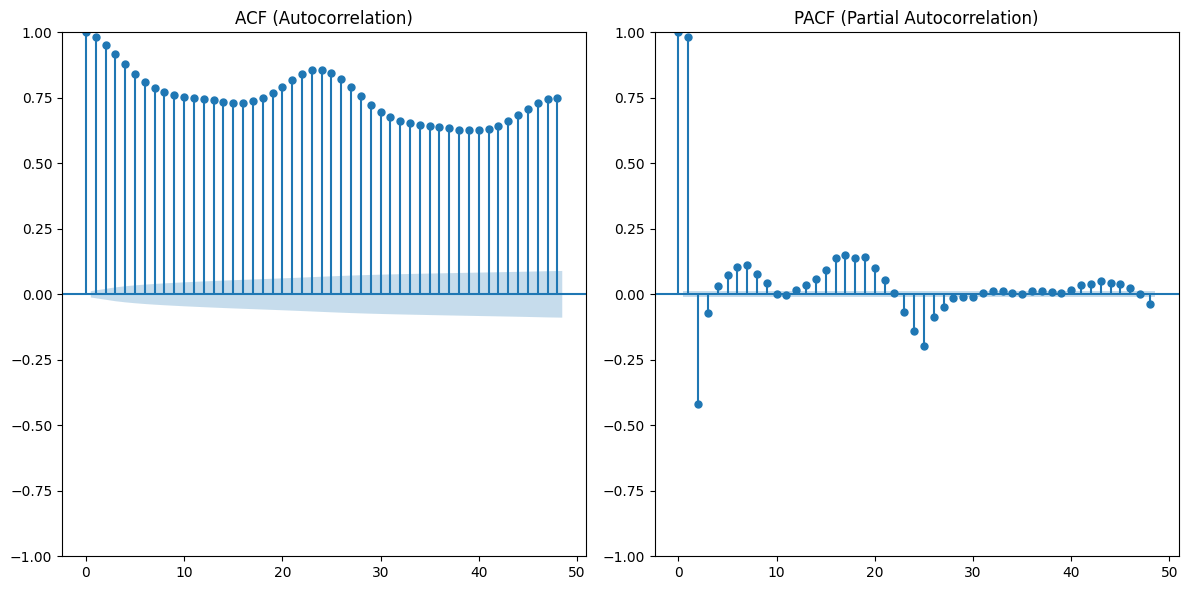

Fitting SARIMA model...
                                        SARIMAX Results                                         
Dep. Variable:     Carbon Intensity gCO₂eq/kWh (direct)   No. Observations:                26280
Model:                   SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -75732.008
Date:                                  Sat, 30 Nov 2024   AIC                         151474.016
Time:                                          12:59:32   BIC                         151514.889
Sample:                                      01-01-2021   HQIC                        151487.215
                                           - 12-31-2023                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0368      0.040      0.92

In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Load datasets for New York (update file paths for your New York data)
data_2021 = pd.read_csv('/Users/aashrithasankineni/Downloads/newyork_carbon_footprint/US-NY-NYIS_2021_hourly.csv')
data_2022 = pd.read_csv('/Users/aashrithasankineni/Downloads/newyork_carbon_footprint/US-NY-NYIS_2022_hourly.csv')
data_2023 = pd.read_csv('/Users/aashrithasankineni/Downloads/newyork_carbon_footprint/US-NY-NYIS_2023_hourly.csv')

# Combine datasets
data_combined = pd.concat([data_2021, data_2022, data_2023], ignore_index=True)

# Convert Datetime to pandas datetime and set as index
data_combined['Datetime (UTC)'] = pd.to_datetime(data_combined['Datetime (UTC)'])
data_combined.set_index('Datetime (UTC)', inplace=True)

# Explicitly set frequency for time index (hourly)
data_combined = data_combined.asfreq('h')

# Select the target column
carbon_intensity = data_combined['Carbon Intensity gCO₂eq/kWh (direct)']

# Plot ACF and PACF for non-seasonal components
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(carbon_intensity.dropna(), lags=48, ax=plt.gca(), title="ACF (Autocorrelation)")
plt.subplot(122)
plot_pacf(carbon_intensity.dropna(), lags=48, ax=plt.gca(), title="PACF (Partial Autocorrelation)")
plt.tight_layout()
plt.show()

# Fit a SARIMA model with seasonal components
# Seasonal order (P, D, Q, S): Choose S=24 for hourly seasonality
print("Fitting SARIMA model...")
sarima_model = SARIMAX(
    carbon_intensity,
    order=(1, 1, 1),  # Non-seasonal (p, d, q)
    seasonal_order=(1, 1, 1, 24),  # Seasonal (P, D, Q, S)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit(disp=False)

# Display model summary
print(sarima_fit.summary())

# Forecast for 2024 (8760 hours for a leap year)
forecast_steps = 8760  # Number of hours in 2024
future_dates = pd.date_range(start='2024-01-01 00:00:00', periods=forecast_steps, freq='h')
forecast_2024 = sarima_fit.forecast(steps=forecast_steps)

# Create a DataFrame for forecasted results
forecast_df = pd.DataFrame({'Datetime (UTC)': future_dates, 'Forecast': forecast_2024})
forecast_df.set_index('Datetime (UTC)', inplace=True)

# Save forecast to a CSV file
forecast_df.to_csv('/Users/aashrithasankineni/Downloads/newyork_carbon_footprint/forecast_2024_hourly_sarima.csv')

# Display a preview of the forecast
print("Hourly Forecast Preview (2024):")
print(forecast_df.head())


In [2]:
import plotly.graph_objects as go

# Create a dynamic graph using Plotly
fig = go.Figure()

# Add hourly forecast to the graph
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df['Forecast'],
    mode='lines',
    name='Hourly Forecast',
    line=dict(color='blue')
))

# Customize layout
fig.update_layout(
    title='Hourly Carbon Intensity Forecast for New York (2024)',
    xaxis_title='Datetime (UTC)',
    yaxis_title='Carbon Intensity (gCO₂eq/kWh)',
    template='plotly_dark',
    legend=dict(x=0, y=1),
)

# Show the graph
fig.show()


In [8]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# File paths for New York electricity price data (2020–2023)
files = [
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2020Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2020Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2020Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2020Q4.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2021Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2021Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2021Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2021Q4.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q4.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q3.csv'
]

# Combine all data
data_combined = pd.concat([pd.read_csv(file, skiprows=3) for file in files], ignore_index=True)

# Parse timestamps and set as index
data_combined['Datetime (UTC)'] = pd.to_datetime(data_combined['UTC Timestamp (Interval Ending)'])
data_combined.set_index('Datetime (UTC)', inplace=True)

# Select relevant electricity price column for New York City
electricity_prices = data_combined['J - New York City LMP']

# Resample to hourly averages
hourly_prices = electricity_prices.resample('h').mean()

# Fit the SARIMA model with seasonality (daily cycle)
seasonal_order = (1, 1, 1, 24)  # Seasonal parameters
sarima_model = SARIMAX(
    hourly_prices,  # Historical data
    order=(1, 1, 1),  # Non-seasonal ARIMA parameters
    seasonal_order=seasonal_order,  # Seasonal parameters
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit(disp=False, maxiter=1000)

# Display model summary
print("SARIMA Model Training Complete.")
print(sarima_fit.summary())

# Save the trained model for later use
sarima_fit.save('/Users/aashrithasankineni/Downloads/newyork_electricity_prices/sarima_model_2020_2023.pkl')

# Forecast for 2024
forecast_steps = 8760  # Number of hours in 2024 (non-leap year)
forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

# Save the forecast results
forecast_mean.to_csv('/Users/aashrithasankineni/Downloads/newyork_electricity_prices/forecast_2024.csv')
print("Forecast saved successfully.")


SARIMA Model Training Complete.
                                     SARIMAX Results                                      
Dep. Variable:              J - New York City LMP   No. Observations:                32856
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -157611.841
Date:                            Tue, 03 Dec 2024   AIC                         315233.682
Time:                                    22:20:07   BIC                         315275.674
Sample:                                01-01-2020   HQIC                        315247.098
                                     - 10-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5463      0.001    670.255      0.000       0.545       0.548
ma.

In [9]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# File paths for forecast and actual data
forecast_path = '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/forecast_2024.csv'
actual_files = [
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q4.csv'
]

# Combine actual data for 2024
actual_combined = pd.concat(
    [pd.read_csv(file, skiprows=3, parse_dates=['UTC Timestamp (Interval Ending)']) for file in actual_files],
    ignore_index=True
)
actual_combined.set_index('UTC Timestamp (Interval Ending)', inplace=True)
actual_prices = actual_combined['J - New York City LMP'].resample('h').mean()

# Load forecast data
forecast_prices = pd.read_csv(forecast_path, index_col=0, parse_dates=True)

# Align timestamps: Merge actual and forecast data
aligned_data = pd.concat([actual_prices, forecast_prices], axis=1, join='inner')
aligned_data.columns = ['Actual', 'Forecast']
aligned_data = aligned_data.dropna()  # Remove NaN values

# Calculate metrics
mae = mean_absolute_error(aligned_data['Actual'], aligned_data['Forecast'])
mse = mean_squared_error(aligned_data['Actual'], aligned_data['Forecast'])
rmse = np.sqrt(mse)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Save metrics to a CSV file
metrics = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse
}
pd.DataFrame([metrics]).to_csv('/Users/aashrithasankineni/Downloads/newyork_electricity_prices/metrics_2024.csv', index=False)
print("Metrics saved successfully.")


Mean Absolute Error (MAE): 102.23
Mean Squared Error (MSE): 12505.12
Root Mean Squared Error (RMSE): 111.83
Metrics saved successfully.


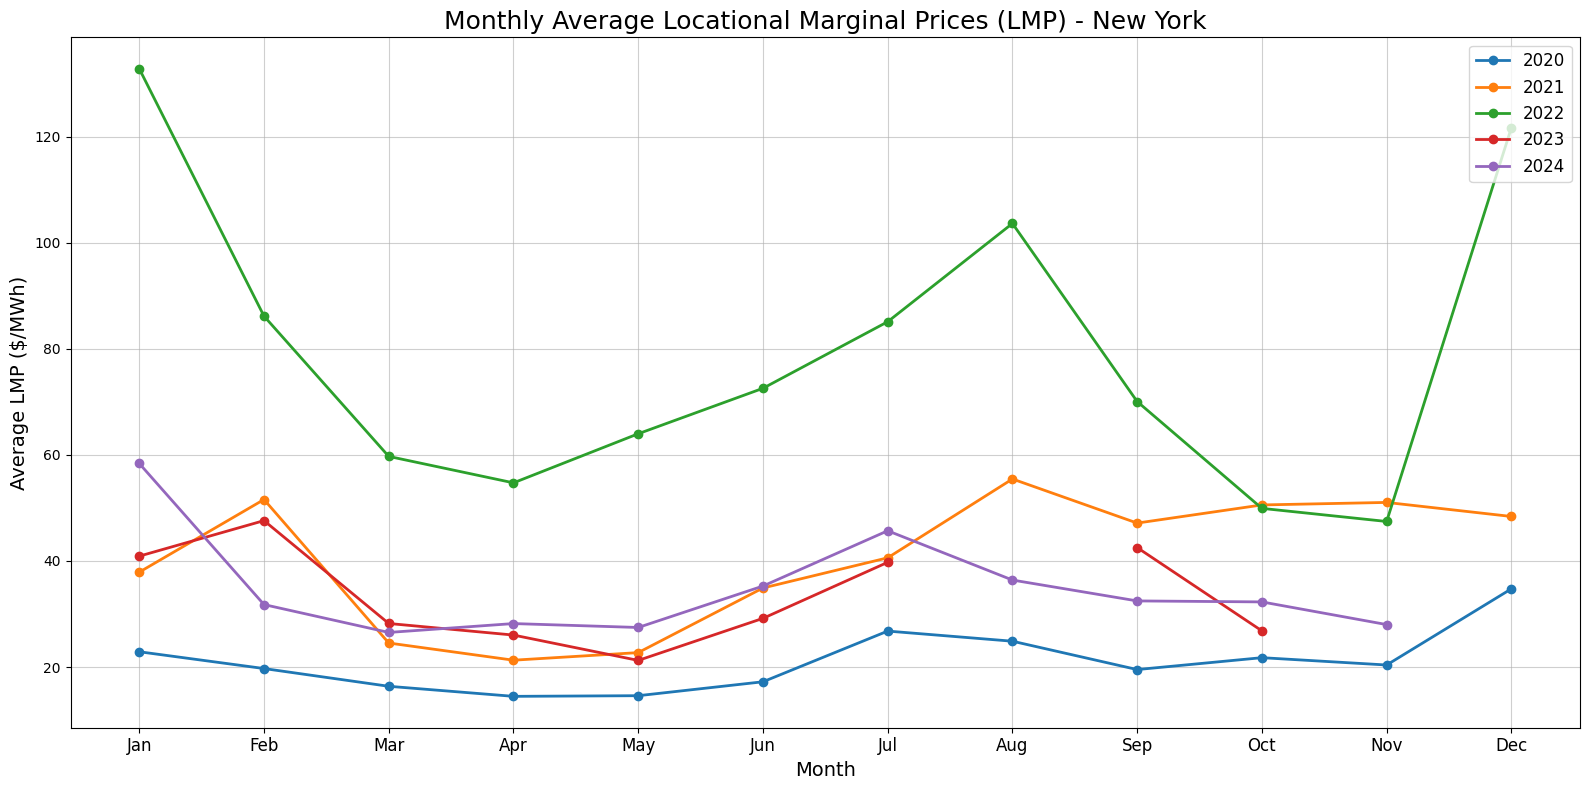

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths for New York data
files_newyork = [
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2020Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2020Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2020Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2020Q4.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2021Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2021Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2021Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2021Q4.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2022Q4.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2023Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q1.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q2.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q3.csv',
    '/Users/aashrithasankineni/Downloads/newyork_electricity_prices/nyiso_lmp_rt_5min_zones_2024Q4.csv'
]

# Combine all files into one DataFrame
data_newyork = pd.concat([pd.read_csv(file, skiprows=3) for file in files_newyork], ignore_index=True)

# Select the best columns for LMP analysis
selected_columns = ['D - North LMP', 'J - New York City LMP', 'K - Long Island LMP']

# Ensure relevant columns exist
if all(col in data_newyork.columns for col in selected_columns):
    # Add average of selected columns
    data_newyork['Average LMP'] = data_newyork[selected_columns].mean(axis=1)
    
    # Convert timestamp column to datetime
    data_newyork['UTC Timestamp (Interval Ending)'] = pd.to_datetime(data_newyork['UTC Timestamp (Interval Ending)'])
    data_newyork['Year'] = data_newyork['UTC Timestamp (Interval Ending)'].dt.year
    data_newyork['Month'] = data_newyork['UTC Timestamp (Interval Ending)'].dt.month

    # Calculate monthly average LMP
    monthly_avg_lmp = data_newyork.groupby(['Year', 'Month'])['Average LMP'].mean().reset_index()

    # Pivot the data for plotting
    monthly_avg_pivot = monthly_avg_lmp.pivot(index='Month', columns='Year', values='Average LMP')

    # Plot the data
    plt.figure(figsize=(16, 8))
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for year in monthly_avg_pivot.columns:
        plt.plot(
            monthly_avg_pivot.index,
            monthly_avg_pivot[year],
            marker='o',
            label=f'{int(year)}',
            linewidth=2
        )

    # Customize the plot
    plt.title('Monthly Average Locational Marginal Prices (LMP) - New York', fontsize=18)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Average LMP ($/MWh)', fontsize=14)
    plt.xticks(range(1, 13), month_labels, fontsize=12)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("Some of the selected columns for LMP analysis are missing.")


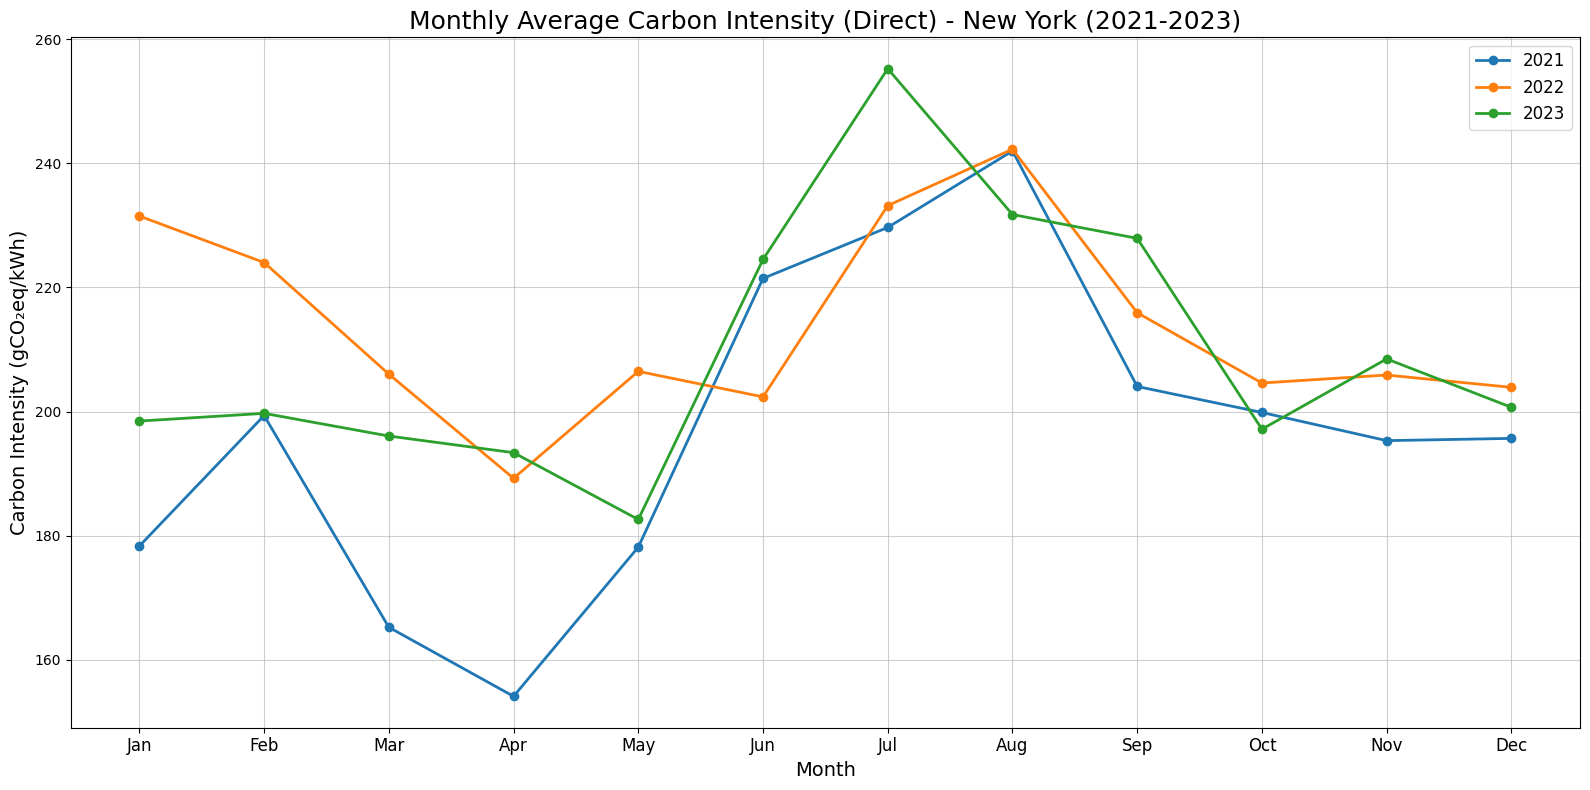

Text(0, 0.5, 'Percentage (%)')

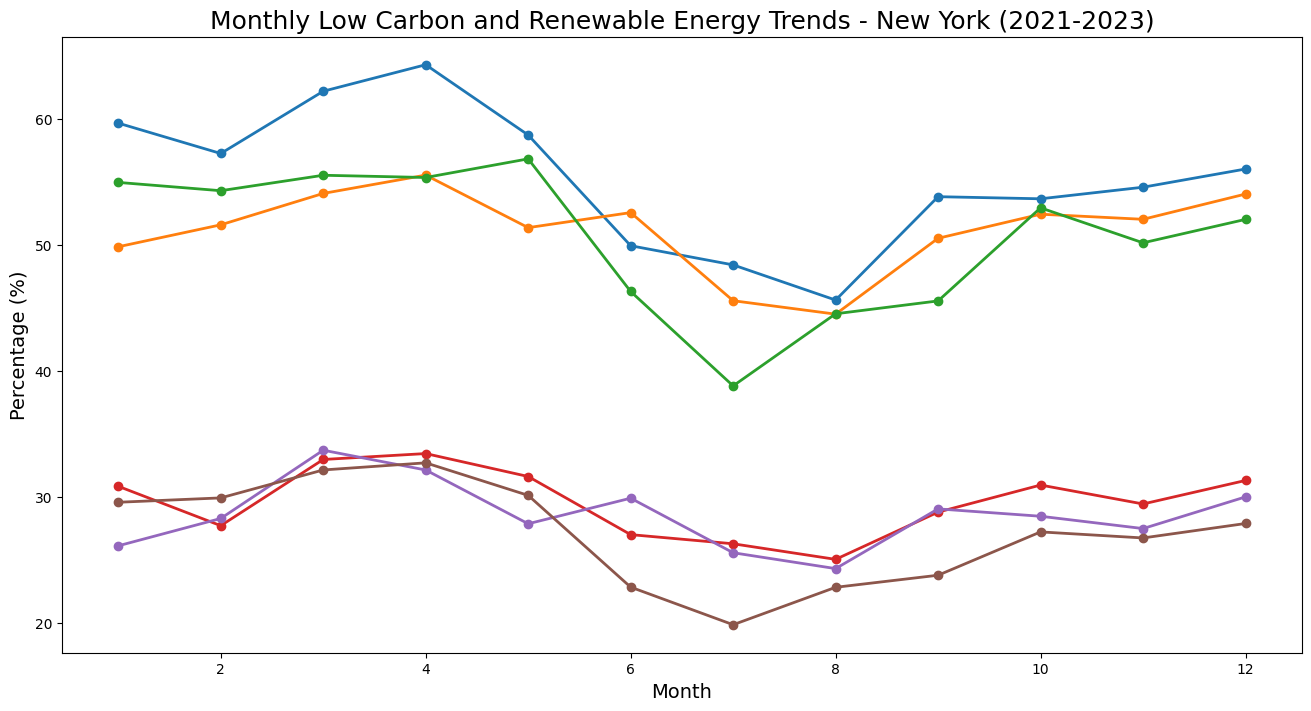

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets for New York using the provided file paths
data_ny_2021 = pd.read_csv('/Users/aashrithasankineni/Downloads/newyork_carbon_footprint/US-NY-NYIS_2021_hourly.csv')
data_ny_2022 = pd.read_csv('/Users/aashrithasankineni/Downloads/newyork_carbon_footprint/US-NY-NYIS_2022_hourly.csv')
data_ny_2023 = pd.read_csv('/Users/aashrithasankineni/Downloads/newyork_carbon_footprint/US-NY-NYIS_2023_hourly.csv')

# Combine the datasets for all years
data_ny_combined = pd.concat([data_ny_2021, data_ny_2022, data_ny_2023], ignore_index=True)

# Convert Datetime column to datetime format
data_ny_combined['Datetime (UTC)'] = pd.to_datetime(data_ny_combined['Datetime (UTC)'])

# Extract Year and Month for grouping
data_ny_combined['Year'] = data_ny_combined['Datetime (UTC)'].dt.year
data_ny_combined['Month'] = data_ny_combined['Datetime (UTC)'].dt.month

# Select numeric columns
numeric_columns = [
    'Carbon Intensity gCO₂eq/kWh (direct)',
    'Low Carbon Percentage',
    'Renewable Percentage',
]

# Group by Year and Month, and calculate the mean
monthly_avg_ny = data_ny_combined.groupby(['Year', 'Month'])[numeric_columns].mean().reset_index()

# Pivot the data for Carbon Intensity plot
pivoted_data_ny = monthly_avg_ny.pivot(index='Month', columns='Year', values='Carbon Intensity gCO₂eq/kWh (direct)')

# Plot Carbon Intensity (Direct) trends for New York
plt.figure(figsize=(16, 8))
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for year in pivoted_data_ny.columns:
    plt.plot(
        pivoted_data_ny.index,
        pivoted_data_ny[year],
        marker='o',
        label=f'{int(year)}',
        linewidth=2
    )

# Customize the plot
plt.title('Monthly Average Carbon Intensity (Direct) - New York (2021-2023)', fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Carbon Intensity (gCO₂eq/kWh)', fontsize=14)
plt.xticks(range(1, 13), month_labels, fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()

# Plot Renewable and Low Carbon Percentage for New York
plt.figure(figsize=(16, 8))
for col in ['Low Carbon Percentage', 'Renewable Percentage']:
    pivoted_data_ny = monthly_avg_ny.pivot(index='Month', columns='Year', values=col)
    for year in pivoted_data_ny.columns:
        plt.plot(
            pivoted_data_ny.index,
            pivoted_data_ny[year],
            marker='o',
            label=f'{col} ({int(year)})',
            linewidth=2
        )

# Customize the plot
plt.title('Monthly Low Carbon and Renewable Energy Trends - New York (2021-2023)', fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
